In [ ]:
# connect to google drive, run this block again after every restart of runtime
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Indoor_model_1118')

Mounted at /content/drive


In [ ]:
import os
import h5py
import time
import csv
import glob

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras

from numpy import load
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ELU
from tensorflow.keras.activations import linear
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import matplotlib
from matplotlib import pyplot
import matplotlib.pylab as plt
import seaborn as sns

In [ ]:
# review (only review) GPU information, run when needed
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 20 02:35:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# define an encoder block
def encoder_block(layer_in, n_filters, strd=(2,2,2), batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, strd=(2,2,2), dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define the standalone generator model
def define_generator(src_image_shape=(32,32,16,5), delta_feature_shape=(3,)):
# def define_generator(src_image_shape=(32,32,16,5)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=src_image_shape) # 32*32*16*5
    in_delta = Input(shape=delta_feature_shape) # 3

    # encoder model
    e0 = encoder_block(in_image, 512, strd=(1,1,1), batchnorm=True) # 32*32*16*512
    e1 = encoder_block(e0, 512, strd=(1,1,1), batchnorm=True) # 32*32*16*512
    e2 = encoder_block(e1, 512, strd=(1,1,1), batchnorm=True) # 32*32*16*512
    e3 = encoder_block(e2, 512, strd=(2,2,2), batchnorm=True) # 16*16*8*512
    e4 = encoder_block(e3, 512, strd=(1,1,1), batchnorm=True) # 16*16*8*512
    e4_ = encoder_block(e4, 512, strd=(1,1,1), batchnorm=True) # 16*16*8*512
    e5 = encoder_block(e4_, 512, strd=(2,2,2), batchnorm=True) # 8*8*4*512
    e6 = encoder_block(e5, 512, strd=(1,1,1), batchnorm=True) # 8*8*4*512
    e6_ = encoder_block(e6, 512, strd=(1,1,1), batchnorm=True) # 8*8*4*512
    e7 = encoder_block(e6_, 512, strd=(2,2,2), batchnorm=True) # 4*4*2*512
    e8 = encoder_block(e7, 512, strd=(1,1,1), batchnorm=True) # 4*4*2*512
    e8_ = encoder_block(e8, 512, strd=(1,1,1), batchnorm=True) # 4*4*2*512
    e9 = encoder_block(e8_, 512, strd=(2,2,2), batchnorm=True) # 2*2*1*512
    e10 = encoder_block(e9, 512, strd=(1,1,1), batchnorm=True) # 2*2*1*512
    e10_ = encoder_block(e10, 512, strd=(1,1,1), batchnorm=True) # 2*2*1*512
    f = Flatten()(e10_) # 2048

    # bottleneck, no batch norm and relu
    b0 = Concatenate(axis=-1)([f, in_delta]) # 2051
    b1 = Dense(2048, activation='relu')(b0)
    b2 = Dense(2048, activation='relu')(b1)
    b3 = Reshape((2,2,1,512))(b2) # 2*2*1*512

    # decoder model
    d9 = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(b3)  # 2*2*1*512
    d9 = BatchNormalization()(d9)
    d9 = Dropout(0.5)(d9)
    d9 = LeakyReLU(alpha=0.2)(d9)

    d9_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d9)  # 2*2*1*512
    d9_ = BatchNormalization()(d9_)
    d9_ = Dropout(0.5)(d9_)
    d9_ = LeakyReLU(alpha=0.2)(d9_)

    d8 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d9_)  # 4*4*2*512
    d8 = BatchNormalization()(d8)
    d8 = Dropout(0.5)(d8)
    d8 = LeakyReLU(alpha=0.2)(d8)

    d8_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d8)  # 4*4*2*512
    d8_ = BatchNormalization()(d8_)
    d8_ = Dropout(0.5)(d8_)
    d8_ = LeakyReLU(alpha=0.2)(d8_)

    d7 = decoder_block(d8_, e7, 512, strd=(1,1,1), dropout=False) # 4*4*2*1024

    d6 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d7)  # 8*8*4*512
    d6 = BatchNormalization()(d6)
    d6 = Dropout(0.5)(d6)
    d6 = LeakyReLU(alpha=0.2)(d6)

    d6_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d6)  # 8*8*4*512
    d6_ = BatchNormalization()(d6_)
    # d6_ = Dropout(0.5)(d6_)
    d6_ = LeakyReLU(alpha=0.2)(d6_)

    d5 = decoder_block(d6_, e5, 512, strd=(1,1,1), dropout=False) # 8*8*4*1024

    d4 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d5)  # 16*16*8*512
    d4 = BatchNormalization()(d4)
    d4 = Dropout(0.5)(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)

    d4_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d4)  # 16*16*8*512
    d4_ = BatchNormalization()(d4_)
    # d4_ = Dropout(0.5)(d4_)
    d4_ = LeakyReLU(alpha=0.2)(d4_)

    d3 = decoder_block(d4_, e3, 512, strd=(1,1,1), dropout=False) # 16*16*8*1024

    d2 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d3) # 32*32*16*512
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.5)(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)

    d1 = decoder_block(d2, e1, 512, strd=(1,1,1), dropout=False) # 32*32*16*1024

    d0 = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d1) # 32*32*16*512
    d0 = BatchNormalization()(d0)
    d0 = Dropout(0.5)(d0)
    d0 = LeakyReLU(alpha=0.2)(d0)

    d0_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d0) # 32*32*16*512
    d0_ = BatchNormalization()(d0_)
    # d0_ = Dropout(0.5)(d0_)
    d0_ = LeakyReLU(alpha=0.2)(d0_)

    # output
    g = Conv3DTranspose(1, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d0_) # 32*32*16*1
    out_image = Activation('sigmoid')(g)

    # define model
    model = Model([in_image, in_delta], out_image)

    print("Generator Summary: \n")
    model.summary(positions = [.4, .68, .8, 1.])
    return model

In [ ]:
# dataset pipeline
def get_data_from_filename(filename):
    npdata = np.load(filename.numpy())
    bnd_mx, xyz_deltas, mag_mx = npdata['arr_0'], npdata['arr_1'], npdata['arr_2']
    uvw_scaler = 1/7.0
    p_scaler = 1/25.0
    bnd_mx[:,:,:,0] *= uvw_scaler
    bnd_mx[:,:,:,1] *= uvw_scaler
    bnd_mx[:,:,:,2] *= uvw_scaler
    bnd_mx[:,:,:,3] *= p_scaler
    mag_mx[:,:,:,0] *= uvw_scaler
    return bnd_mx, xyz_deltas, mag_mx

def get_data_wrapper(filename):
    # Assuming here that both your data and label is float type.
    bnd_mx, xyz_deltas, mag_mx = tf.py_function(get_data_from_filename, [filename], [tf.float32, tf.float32, tf.float32])
    return tf.data.Dataset.from_tensors((bnd_mx, xyz_deltas, mag_mx))

def set_shape(m1, d, m2):
    m1.set_shape((32, 32, 16, 5))
    d.set_shape((3,))
    m2.set_shape((32, 32, 16, 1))
    return m1, d, m2

# Create dataset of filenames.
test_percent = 0.01
batch_size = 16
npz_folder_path = "/content/drive/MyDrive/Indoor_model_1118/Indoor_Dataset_D/CFD_Mag_Dataset"
filelist = glob.glob(npz_folder_path + '/*.npz')
train_num = int((len(filelist)/batch_size)*(1.0-test_percent))
print("number of data point in training set: ", train_num)
ds = tf.data.Dataset.from_tensor_slices(filelist)
ds = ds.flat_map(get_data_wrapper)
ds = ds.map(set_shape)
ds = ds.batch(batch_size)
ds_train = ds.take(train_num)
ds_test = ds.skip(train_num)

number of data point in training set:  742


dx:  0.12096774
dy:  0.22580644
dz:  0.2


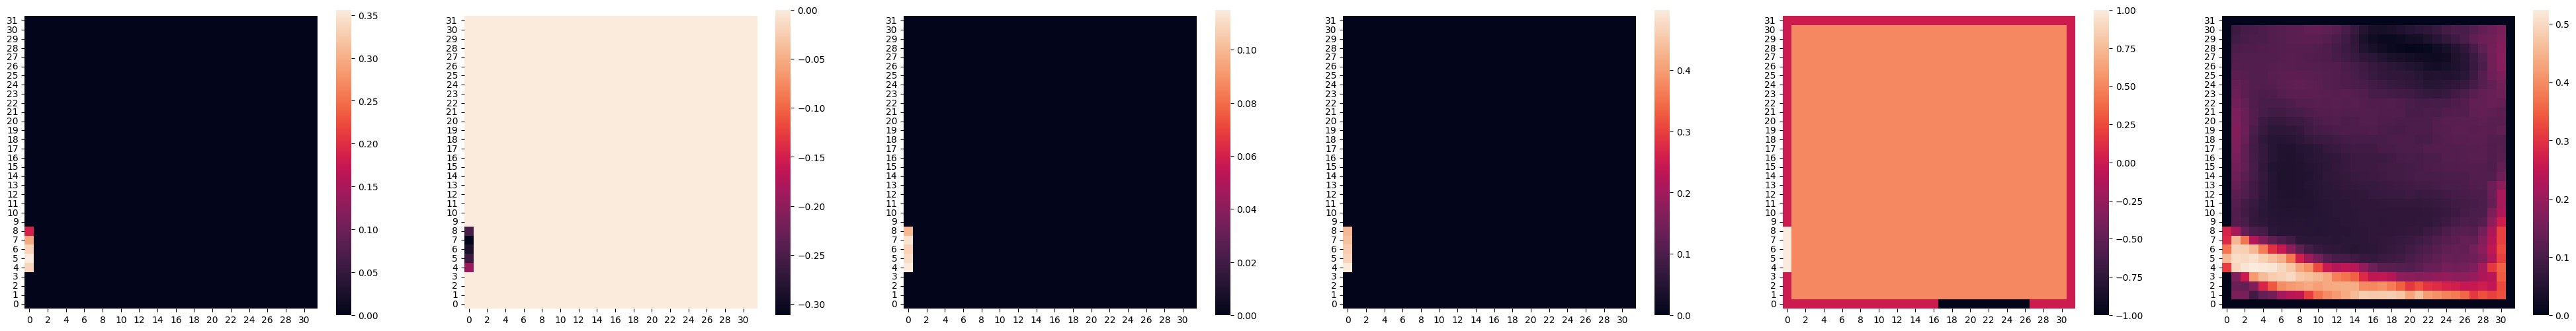

In [ ]:
# print data example
z = 10
for bnd_mx, xyz_deltas, mag_mx in ds_test.skip(2).take(1):
    print("dx: ", xyz_deltas.numpy()[0,0])
    print("dy: ", xyz_deltas.numpy()[0,1])
    print("dz: ", xyz_deltas.numpy()[0,2])
    ub, vb, wb, pb, patb = bnd_mx.numpy()[0,:,:,:,0], bnd_mx.numpy()[0,:,:,:,1], bnd_mx.numpy()[0,:,:,:,2], bnd_mx.numpy()[0,:,:,:,3], bnd_mx.numpy()[0,:,:,:,4]
    magc = mag_mx.numpy()[0,:,:,:,0]

    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(50, 6))
    sns.heatmap(ub[:,:,z].T, ax = ax[0], square = True)
    ax[0].invert_yaxis()
    sns.heatmap(vb[:,:,z].T, ax = ax[1], square = True)
    ax[1].invert_yaxis()
    sns.heatmap(wb[:,:,z].T, ax = ax[2], square = True)
    ax[2].invert_yaxis()
    sns.heatmap(pb[:,:,z].T, ax = ax[3], square = True)
    ax[3].invert_yaxis()
    sns.heatmap(patb[:,:,z].T, ax = ax[4], square = True)
    ax[4].invert_yaxis()
    sns.heatmap(magc[:,:,z].T, ax = ax[5], square = True)
    ax[5].invert_yaxis()

In [ ]:
generator = define_generator()
generator_optimizer = Adam(0.000002, beta_1=0.9) #lr starts as 0.0002 # ep45 0.00002 # ep185 0.000002

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Generator Summary: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #     Connected to        
 input_1 (InputLayer)                  [(None, 32, 32, 16, 5)]    0           []                  
                                                                                                  
 conv3d (Conv3D)                       (None, 32, 32, 16, 512)    69632       ['input_1[0][0]']   
                                                                                                  
 batch_normalization (BatchNormalizati  (None, 32, 32, 16, 512)   2048        ['conv3d[0][0]']    
 on)                                                                                              
                                                                                                  
 leaky_re_lu (LeakyReLU)               (None, 32, 32, 16, 512)    0      

In [ ]:
@tf.function
def resnet_train_iteration(bnd, delta, cfd):
    with tf.GradientTape() as gen_tape:
        generated_images = generator([bnd, delta], training=True)
        # gen_loss = MeanAbsoluteError()(generated_images, cfd)
        loss_factor = 2.5
        gen_loss = MeanAbsoluteError()(generated_images, cfd, sample_weight=K.abs(tf.subtract(bnd[:,:,:,:,4], 0.1))) * loss_factor

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss

In [ ]:
def train(dataset, epochs, starting_epoch):
    f = open("/content/drive/MyDrive/Indoor_model_1118/Indoor_model_loss_mag_0801/Indoor_model_loss_mag_0801_" + str(starting_epoch) + ".csv", "w")
    writer = csv.writer(f)
    writer.writerow(list(range(train_num)))
    f.close()

    for epoch in range(epochs):
        train_loss = []
        start = time.time()
        for i, (bnd_mx, xyz_deltas, cfd_mx) in enumerate(dataset):
            gen_loss = resnet_train_iteration(bnd_mx, xyz_deltas, cfd_mx)
            print('>%d, g[%.5f]' % (i+1, gen_loss))
            train_loss.append(gen_loss.numpy())
        with open('/content/drive/MyDrive/Indoor_model_1118/Indoor_model_loss_mag_0801/Indoor_model_loss_mag_0801_' + str(starting_epoch) + '.csv', 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(train_loss)

        # save the model every 10 epochs
        if (epoch+1) % 5 == 0:
            g_filename = '/content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_mag/Indoor_model_mag_0801_%06d.h5' % (starting_epoch+epoch+1)
            generator.save(g_filename)
            print('>save g_model: %s' % (g_filename))

        print('Time for epoch {} is {} sec'.format(starting_epoch + epoch + 1, time.time()-start))

In [ ]:
train(ds_train, epochs=50, starting_epoch=300)

>1, g[0.01361]
>2, g[0.01460]
>3, g[0.01308]
>4, g[0.01351]
>5, g[0.01484]
>6, g[0.01266]
>7, g[0.01490]
>8, g[0.01339]
>9, g[0.01146]
>10, g[0.01358]
>11, g[0.01516]
>12, g[0.01348]
>13, g[0.01344]
>14, g[0.01320]
>15, g[0.01353]
>16, g[0.01280]
>17, g[0.01351]
>18, g[0.01372]
>19, g[0.01228]
>20, g[0.01305]
>21, g[0.01537]
>22, g[0.01375]
>23, g[0.01399]
>24, g[0.01359]
>25, g[0.01241]
>26, g[0.01222]
>27, g[0.01373]
>28, g[0.01321]
>29, g[0.01230]
>30, g[0.01087]
>31, g[0.01488]
>32, g[0.01317]
>33, g[0.01260]
>34, g[0.01426]
>35, g[0.01284]
>36, g[0.01389]
>37, g[0.01467]
>38, g[0.01204]
>39, g[0.01450]
>40, g[0.01330]
>41, g[0.01171]
>42, g[0.01363]
>43, g[0.01478]
>44, g[0.01312]
>45, g[0.01423]
>46, g[0.01309]
>47, g[0.01168]
>48, g[0.01102]
>49, g[0.01197]
>50, g[0.01394]
>51, g[0.01598]
>52, g[0.01298]
>53, g[0.01317]
>54, g[0.01351]
>55, g[0.01264]
>56, g[0.01457]
>57, g[0.01404]
>58, g[0.01196]
>59, g[0.01364]
>60, g[0.01443]
>61, g[0.01323]
>62, g[0.01321]
>63, g[0.01497]
>

>742, g[0.01395]
>save g_model: /content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_mag/Indoor_model_mag_0801_000290.h5
Time for epoch 290 is 621.9326632022858 sec
>1, g[0.01350]
>2, g[0.01453]
>3, g[0.01314]
>4, g[0.01357]
>5, g[0.01486]
>6, g[0.01264]
>7, g[0.01505]
>8, g[0.01299]
>9, g[0.01139]
>10, g[0.01367]
>11, g[0.01508]
>12, g[0.01318]
>13, g[0.01341]
>14, g[0.01300]
>15, g[0.01346]
>16, g[0.01280]
>17, g[0.01339]
>18, g[0.01359]
>19, g[0.01219]
>20, g[0.01296]
>21, g[0.01512]
>22, g[0.01376]
>23, g[0.01389]
>24, g[0.01364]
>25, g[0.01246]
>26, g[0.01222]
>27, g[0.01357]
>28, g[0.01307]
>29, g[0.01217]
>30, g[0.01079]
>31, g[0.01467]
>32, g[0.01306]
>33, g[0.01252]
>34, g[0.01415]
>35, g[0.01283]
>36, g[0.01372]
>37, g[0.01455]
>38, g[0.01208]
>39, g[0.01460]
>40, g[0.01321]
>41, g[0.01145]
>42, g[0.01360]
>43, g[0.01465]
>44, g[0.01318]
>45, g[0.01443]
>46, g[0.01324]
>47, g[0.01157]
>48, g[0.01103]
>49, g[0.01216]
>50, g[0.01391]
>51, g[0.01605]
>52, g[0.01286]
>53, 

>742, g[0.01397]
>save g_model: /content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_mag/Indoor_model_mag_0801_000295.h5
Time for epoch 295 is 621.7541999816895 sec
>1, g[0.01348]
>2, g[0.01436]
>3, g[0.01315]
>4, g[0.01336]
>5, g[0.01480]
>6, g[0.01247]
>7, g[0.01494]
>8, g[0.01317]
>9, g[0.01138]
>10, g[0.01349]
>11, g[0.01512]
>12, g[0.01344]
>13, g[0.01356]
>14, g[0.01300]
>15, g[0.01393]
>16, g[0.01271]
>17, g[0.01351]
>18, g[0.01344]
>19, g[0.01230]
>20, g[0.01296]
>21, g[0.01499]
>22, g[0.01360]
>23, g[0.01385]
>24, g[0.01370]
>25, g[0.01217]
>26, g[0.01224]
>27, g[0.01362]
>28, g[0.01317]
>29, g[0.01212]
>30, g[0.01074]
>31, g[0.01467]
>32, g[0.01295]
>33, g[0.01246]
>34, g[0.01412]
>35, g[0.01277]
>36, g[0.01365]
>37, g[0.01451]
>38, g[0.01196]
>39, g[0.01457]
>40, g[0.01324]
>41, g[0.01164]
>42, g[0.01375]
>43, g[0.01449]
>44, g[0.01310]
>45, g[0.01422]
>46, g[0.01318]
>47, g[0.01167]
>48, g[0.01098]
>49, g[0.01201]
>50, g[0.01389]
>51, g[0.01581]
>52, g[0.01272]
>53, 

>742, g[0.01383]
>save g_model: /content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_mag/Indoor_model_mag_0801_000300.h5
Time for epoch 300 is 621.8357727527618 sec


In [ ]:
g_filename = "/content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_mag/Indoor_model_mag_0801_000300.h5"
generator = load_model(g_filename, compile=False)

1/1 [==============================] - 2s 2s/step


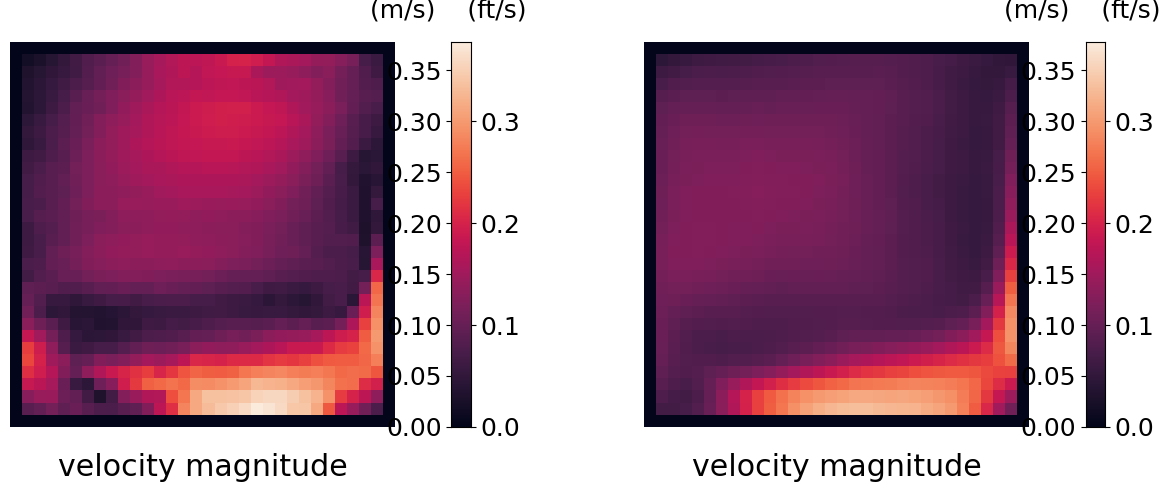

In [ ]:
batch_ind = 2
z = 14 # 0~16

matplotlib.rcParams.update({'font.size': 18})
for bnd_mx, xyz_deltas, cfd_mx in ds_test.skip(batch_ind).take(1):
# for bnd_mx, xyz_deltas, cfd_mx in ds_train.skip(batch_ind).take(1):
    pred_mx = generator.predict([bnd_mx[0:1,:,:,:,:], xyz_deltas[0:1,:]])
    u_min, u_max = np.amin(cfd_mx[0,:,:,z,0], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,0], axis=(0,1))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ax[0] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,0].T, ax = ax[0], square = True, vmin=u_min, vmax=u_max)
    ax[0].invert_yaxis()
    ax[0].axis('off')
    ax[0].set_title("velocity magnitude", y=-0.15)
    ax[0].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[0].collections[0].colorbar

    pos0 = cbar0.ax.get_position()
    #newpos0 = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
    #newlabel0 = (newpos0*3.28084).round(2)

    pos0.x0 += 0.02
    pos0.x1 += 0.02
    ax1 = cbar0.ax
    ax1.set_aspect('auto')
    ax1.set_position(pos0)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-45, y=1.05)

    ax2 = ax1.twinx()
    ax2.set_position(pos0)
    ax2.set_ylim([u_min, u_max])
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    #ax2.set_yticks(newpos0)
    #ax2.set_yticklabels(newlabel0)

    ax[1] = sns.heatmap(pred_mx[0,:,:,z,0].T, ax = ax[1], square = True, vmin=u_min, vmax=u_max)
    ax[1].invert_yaxis()
    ax[1].axis('off')
    ax[1].set_title("velocity magnitude", y=-0.15)
    ax[1].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar1 = ax[1].collections[0].colorbar

    pos1 = cbar1.ax.get_position()
    #newpos1 = np.interp(cbar1.ax.get_yticks(), cbar1.ax.get_ylim(), cbar1.get_clim())
    #newlabel1 = (newpos1*3.28084).round(2)

    pos1.x0 += 0.02
    pos1.x1 += 0.02
    ax3 = cbar1.ax
    ax3.set_aspect('auto')
    ax3.set_position(pos1)
    ax3.yaxis.set_ticks_position('left')
    ax3.yaxis.set_label_position('left')
    ax3.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-45, y=1.05)

    ax4 = ax3.twinx()
    ax4.set_position(pos1)
    ax4.set_ylim([u_min, u_max])
    ax4.yaxis.set_ticks_position('right')
    ax4.yaxis.set_label_position('right')
    #ax4.set_yticks(newpos1)
    #ax4.set_yticklabels(newlabel1)

In [ ]:
csv_file_pth = "/content/drive/MyDrive/Indoor_model_1118/Indoor_model_loss_mag_0801/Indoor_model_loss_mag_0801_50.csv"
df = pd.read_csv(csv_file_pth)
df

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,561
0,0.009575,0.011697,0.010054,0.011662,0.010635,0.009574,0.009429,0.009679,0.009307,0.009700,...,0.009066,0.008768,0.008867,0.010482,0.010063,0.009238,0.009553,0.009686,0.009039,0.010178
1,0.009779,0.011650,0.009887,0.011680,0.010606,0.009766,0.009404,0.009719,0.009308,0.009818,...,0.008980,0.008546,0.008974,0.010509,0.010005,0.009173,0.009657,0.009619,0.008987,0.009981
2,0.009801,0.011791,0.009955,0.011681,0.010717,0.009569,0.009488,0.009646,0.009170,0.009713,...,0.009102,0.008597,0.008794,0.010619,0.009907,0.009101,0.009632,0.009562,0.008958,0.010119
3,0.009634,0.011619,0.009902,0.011510,0.010748,0.009645,0.009488,0.009709,0.009276,0.009674,...,0.009037,0.008537,0.008830,0.010563,0.009940,0.009175,0.009576,0.009518,0.008990,0.010086
4,0.009703,0.011681,0.009898,0.011463,0.010554,0.009474,0.009516,0.009530,0.009258,0.009648,...,0.009048,0.008571,0.008799,0.010561,0.009885,0.009165,0.009731,0.009566,0.008949,0.010019
5,0.009704,0.011619,0.009919,0.011443,0.010661,0.009662,0.009507,0.009724,0.009187,0.009609,...,0.008908,0.008559,0.008907,0.010686,0.009946,0.009093,0.009568,0.009419,0.008873,0.010162
6,0.009614,0.011408,0.009836,0.011630,0.010755,0.009596,0.009491,0.009482,0.009031,0.009748,...,0.009177,0.008487,0.008748,0.010601,0.009717,0.009150,0.009567,0.009558,0.008864,0.009896
7,0.009623,0.011589,0.010021,0.011544,0.010568,0.009591,0.009378,0.009614,0.009082,0.009654,...,0.009247,0.008639,0.008827,0.010620,0.009976,0.009193,0.009617,0.009544,0.008961,0.010015
8,0.009778,0.011752,0.009835,0.011666,0.010729,0.009526,0.009552,0.009609,0.009185,0.009738,...,0.009036,0.008524,0.008655,0.010352,0.009760,0.009113,0.009581,0.009559,0.008999,0.009889
9,0.009859,0.011625,0.009848,0.011663,0.010650,0.009511,0.009393,0.009491,0.009146,0.009758,...,0.008954,0.008658,0.008672,0.010469,0.009798,0.009215,0.009640,0.009562,0.008933,0.009889


<Axes: >

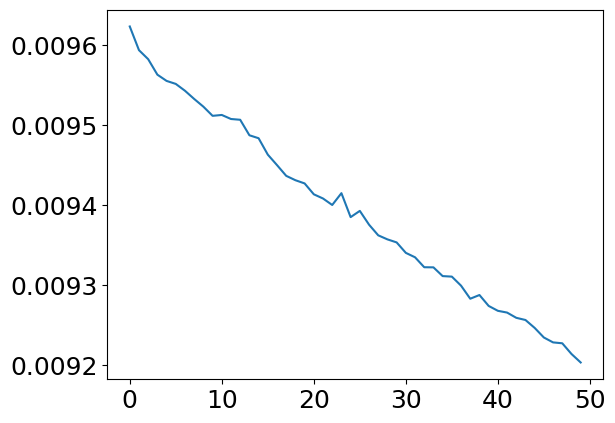

In [ ]:
df.mean(axis=1).plot()

In [ ]:
# tensorflow approach ==========================================
# Create test dataset 3000
test_batch_size = 256
test_folder_path = "/content/drive/MyDrive/Indoor_model_1118/Indoor_Dataset_D_test/CFD_Mag_Dataset"
test_3000_filelist = sorted(glob.glob(npz_folder_path + '/*.npz'), key = lambda path: int(path.replace(".npz","").split("indoor_mag_iteration_")[1]))
ds_3000_test = tf.data.Dataset.from_tensor_slices(test_3000_filelist)
ds_3000_test = ds_3000_test.flat_map(get_data_wrapper)
ds_3000_test = ds_3000_test.map(set_shape)
ds_3000_test = ds_3000_test.batch(batch_size)

In [ ]:
# tensorflow approach ==========================================
epoch_list = range(205, 305, 5)
mean_loss_list = []
for k in epoch_list:
    start = time.time()
    g_filename = '/content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_mag/Indoor_model_mag_0801_%06d.h5' % (k)
    model = load_model(g_filename, compile=False)
    loss_list = []
    for i, (bnd, xyz_deltas, mag) in enumerate(ds_3000_test):
        generated_images = model.predict([bnd, xyz_deltas])
        loss_factor = 2.5
        gen_loss = MeanAbsoluteError()(generated_images, mag, sample_weight=K.abs(tf.subtract(bnd[:,:,:,:,4], 0.1))) * loss_factor
        loss_list.append(gen_loss.numpy())
    mean_loss_list.append(np.mean(loss_list))
    print('Time for epoch {} is {} sec'.format(k, time.time()-start))
df = pd.DataFrame({"epoch": epoch_list, "loss": mean_loss_list})
df.to_csv("/content/drive/MyDrive/Indoor_model_1118/Indoor_test_loss_mag_0801.csv", index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Time for epoch 270 is 272.06604623794556 sec
1/1 [==============================] - 0s 27ms/step
Time for epoch 275 is 279.1586973667145 sec
1/1 [==============================] - 0s 31ms/step
Time for epoch 280 is 279.0359604358673 sec
1/1 [==============================] - 0s 27ms/step
Time for epoch 285 is 273.88510513305664 sec
1/1 [==============================] - 0s 28ms/step
Time for epoch 290 is 273.35137724876404 sec
1/1 [==============================] - 0s 29ms/step
Time for epoch 295 is 272.2928988933563 sec
1/1 [==============================] - 0s 27ms/step
Time for epoch 300 is 264.9804780483246 sec


Text(0.5, 1.0, 'Testing Loss Trajectory')

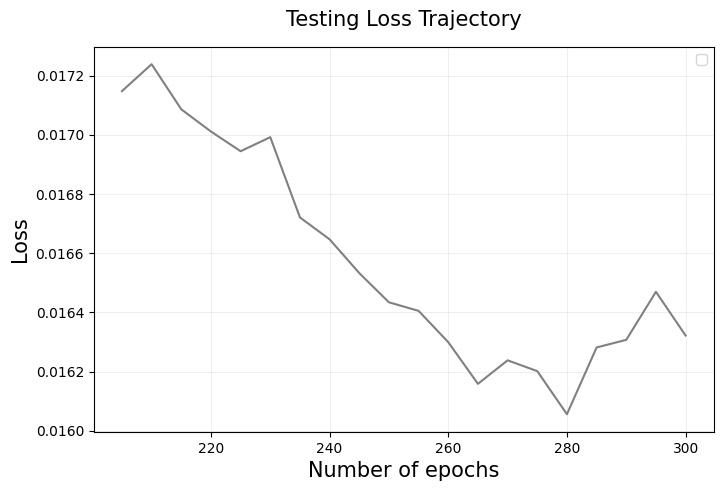

In [ ]:
df_test_lost = pd.read_csv("/content/drive/MyDrive/Indoor_model_1118/Indoor_test_loss_mag_0801.csv")

plt.figure(figsize = (8, 5))
plt.plot(df_test_lost.epoch, df_test_lost.loss, color='grey')
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Testing Loss Trajectory', fontsize=15, pad = 15)